# Import of DST data

In [1]:
import numpy as np
import pandas as pd
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

In [2]:
death = DstApi('FOD207')
pop = DstApi('FOLK1A')

In [3]:
tabsum_pop = pop.tablesummary(language='en')
display(tabsum_pop)
tabsum_death = death.tablesummary(language='en')
display(tabsum_death)

Table FOLK1A: Population at the first day of the quarter by region, sex, age, marital status and time
Last update: 2023-02-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,105,000,All Denmark,851,Aalborg,False
1,KØN,3,TOT,Total,2,Women,False
2,ALDER,127,IALT,Total,125,125 years,False
3,CIVILSTAND,5,TOT,Total,F,Divorced,False
4,Tid,61,2008K1,2008Q1,2023K1,2023Q1,True


Table FOD207: Deaths by region, age, sex and time
Last update: 2023-02-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,105,000,All Denmark,851,Aalborg,False
1,ALDER,101,TOT,"Age, total",99-,99 years and over,False
2,KØN,2,M,Men,K,Women,False
3,Tid,17,2006,2006,2022,2022,True


In [4]:
params_pop = pop._define_base_params(language='en')
params_death = death._define_base_params(language='en')

In [5]:
variables_pop = params_pop['variables']
variables_pop[0]['values'] = ['000']
variables_pop[1]['values'] = ['TOT']
variables_pop[3]['values'] = ['TOT']
variables_pop[4]['values'] = ['2022K1']

variables_death = params_death['variables']
variables_death[0]['values'] = ['000']
variables_death[3]['values'] = ['2022']


In [6]:
pop_api = pop.get_data(params = params_pop)
death_api = death.get_data(params = params_death)

display(pop_api)
display(death_api)

,OMRÅDE,KØN,ALDER,CIVILSTAND,TID,INDHOLD
0,All Denmark,Total,0 years,Total,2022Q1,63602
1,All Denmark,Total,1 year,Total,2022Q1,61514
2,All Denmark,Total,10 years,Total,2022Q1,62282
3,All Denmark,Total,100 years,Total,2022Q1,528
4,All Denmark,Total,101 years,Total,2022Q1,330
...,...,...,...,...,...,...
107,All Denmark,Total,96 years,Total,2022Q1,2432
108,All Denmark,Total,97 years,Total,2022Q1,1792
109,All Denmark,Total,98 years,Total,2022Q1,1203
110,All Denmark,Total,99 years,Total,2022Q1,720


,OMRÅDE,ALDER,KØN,TID,INDHOLD
0,All Denmark,0 years,Women,2022,91
1,All Denmark,0 years,Men,2022,103
2,All Denmark,1 year,Women,2022,4
3,All Denmark,1 year,Men,2022,4
4,All Denmark,10 years,Men,2022,1
...,...,...,...,...,...
194,All Denmark,98 years,Men,2022,104
195,All Denmark,99 years and over,Women,2022,801
196,All Denmark,99 years and over,Men,2022,177
197,All Denmark,"Age, total",Women,2022,29066


In [16]:
# rename columns 
pop_clean = pop_api.rename(columns={'INDHOLD': 'Population', 'ALDER': 'Age'})
death_clean = death_api.rename(columns={'INDHOLD': 'Deaths', 'ALDER': 'Age'})

# split age into two columns and removes second column
pop_clean[['Age', 'Age2']] = pop_clean['Age'].str.split(' ', 1, expand=True)
pop_clean = pop_clean.drop(columns=['Age2'])
death_clean[['Age', 'Age2']] = death_clean['Age'].str.split(' ', 1, expand=True)

# drops obsolote columns
pop_clean = pop_clean.drop(columns=['TID', 'OMRÅDE', 'KØN', 'CIVILSTAND'])
death_clean = death_clean.drop(columns=['TID', 'OMRÅDE'])

# drops rows where age is not an integer
pop_clean = pop_clean[pop_clean['Age'].apply(lambda x: x.isnumeric())]
death_clean = death_clean[death_clean['Age'].apply(lambda x: x.isnumeric())]

# removes numbers above age 98
pop_clean = pop_clean[pop_clean['Age'].apply(lambda x: int(x) < 99)]
death_clean = death_clean[death_clean['Age'].apply(lambda x: int(x) < 99)]

# set age to int sort by and reset index
pop_clean['Age'] = pop_clean['Age'].astype(int)
pop_clean = pop_clean.sort_values(by=['Age']).reset_index(drop=True)
death_clean['Age'] = death_clean['Age'].astype(int)
death_clean = death_clean.sort_values(by=['Age']).reset_index(drop=True)

# sums death by age
death_clean = death_clean.groupby(['Age']).sum().reset_index()


display(pop_clean)
display(death_clean)

,Age,Population
0,0,63602
1,1,61514
2,2,61864
3,3,62135
4,4,62297
...,...,...
94,94,4123
95,95,3303
96,96,2432
97,97,1792


,Age,Deaths
0,0,194
1,1,8
2,2,4
3,3,8
4,4,6
...,...,...
94,94,1157
95,95,970
96,96,835
97,97,615


In [8]:
# merge dataframes

df = pd.merge(pop_clean, death_clean, on='Age', how='outer')

# calculate death rate
df['Death rate'] = df['Deaths'] / df['Population']

# instert 99 and set deathrate to 1 using pandas concat
df = pd.concat([df, pd.DataFrame([[99, 0, 0, 1]], columns=df.columns)]).reset_index(drop=True)
display(df)

,Age,Population,Deaths,Death rate
0,0,63602,194,0.003050
1,1,61514,8,0.000130
2,2,61864,4,0.000065
3,3,62135,8,0.000129
4,4,62297,6,0.000096
...,...,...,...,...
95,95,3303,970,0.293672
96,96,2432,835,0.343339
97,97,1792,615,0.343192
98,98,1203,464,0.385702


In [9]:
# convert death rate to np. array
death_rate = df['Death rate'].to_numpy()

beta = 1-death_rate

beta

array([0.99694978, 0.99986995, 0.99993534, 0.99987125, 0.99990369,
       0.9999523 , 0.99994987, 0.99994929, 0.99993184, 0.99995085,
       0.99998394, 0.99989528, 0.99993994, 0.99992752, 0.99994126,
       0.99986958, 0.99988308, 0.99983934, 0.99986895, 0.99966739,
       0.99964921, 0.99975851, 0.99971882, 0.99959395, 0.99968198,
       0.99969802, 0.99974404, 0.99963766, 0.99966406, 0.99975427,
       0.99950401, 0.99950394, 0.99952852, 0.99956886, 0.99950791,
       0.99953015, 0.99947369, 0.99943891, 0.99928621, 0.99913363,
       0.99934142, 0.99905593, 0.99894012, 0.99864463, 0.99883125,
       0.99883273, 0.99861435, 0.99866877, 0.99815755, 0.99810896,
       0.99780228, 0.99766122, 0.99732684, 0.99697792, 0.99682372,
       0.99677044, 0.99584241, 0.99505649, 0.9950062 , 0.9944297 ,
       0.99370451, 0.99244138, 0.99234033, 0.99107843, 0.99059811,
       0.98907996, 0.9865449 , 0.98535247, 0.98542703, 0.98377348,
       0.98218215, 0.98079606, 0.97927079, 0.97788722, 0.97649

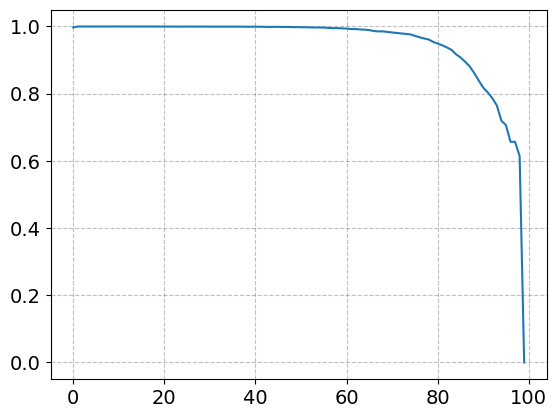

In [10]:
plot = plt.plot(beta)

